# Two Sector Hank (Formal and Informal No Labor Mobility)
There is a continuum of two ex-ante identical households. Type one works in sector formal ($f$) and the other in sector ($i$). 
Only the formal type can be taxed by the government.

Aggregation is given with size of each sector ($p$); eg 0.5:
$$
C = p * C^f + C^i * (1 - p) \\
A = p * A^f + A^i * (1 - p) \\
$$

Disposable income ($Z$) is a function of output ($Y$), wage rate ($w$) and taxes ($T$):
$$
Z = Y - T \\
Z^f = Y * (p/ (1 - p)) * w - T / (1 - p) \\
Z^i = Y / ((p/ (1 - p)) * w)
$$

In [1]:
# from ConsIndShockModel_HANK_NEW import IndShockConsumerType 
from TwoSectorModel_HANK import TwoSectorMarkovConsumerType
import sequence_jacobian as sj  # SSJ will allow us to define blocks, models, compute IRFs, etc
from sequence_jacobian.classes import JacobianDict, SteadyStateDict
from sequence_jacobian import het, simple, create_model              # functions
import matplotlib.pyplot as plt
import numpy as np
import time
from copy import copy, deepcopy

from scipy import optimize

In [30]:
def show_irfs(irfs_list, variables, labels=[" "], ylabel=r"Percentage points (dev. from ss)", T_plot=50, figsize=(18, 6)):
    if len(irfs_list) != len(labels):
        labels = [" "] * len(irfs_list)
    n_var = len(variables)
    fig, ax = plt.subplots(1, n_var, figsize=figsize, sharex=True)
    for i in range(n_var):
        # plot all irfs
        for j, irf in enumerate(irfs_list):
            ax[i].plot(100 * irf[variables[i]][:50], label=labels[j])
        ax[i].set_title(variables[i])
        ax[i].set_xlabel(r"$t$")
        if i==0:
            ax[i].set_ylabel(ylabel)
        ax[i].legend()
    plt.show()

In [3]:
# Define the Markov transition matrix for sector f(ormal) to i(nformal)
p_f_to_i = 0.0
p_i_to_f = 0.0
p_f_to_f = 1 - p_f_to_i
p_i_to_i = 1 - p_i_to_f

MrkvArray = np.array(
    [
        [
            p_f_to_f
        ,
            p_f_to_i
        ],
        [
           p_i_to_f
        ,
            p_i_to_i
        ]
    ]
)

NSectors = 2

In [4]:
## psize is the size of the formal sector.
psize = 0.5
pformal_share = psize/(1-psize)
wage_share = 1.25

In [5]:
UnempPrb_f = 0.05
IncUnemp_f = 0.7

In [6]:
# Defining steady state values of the economy
def fiscal_ss(B, r, G): 
    T = (1 + r) * B + G - B #+ (UnempPrb_f * IncUnemp_f) *psize    
    return T

r_ss = 1.03 - 1
G_ss = .2
B_ss = 0.25 # this is lower than the tutorial by Straub et al. because need Higher MPC
Y_ss = 1.0

T_ss = fiscal_ss(B_ss,r_ss,G_ss)
print('T_ss: ' +str(T_ss))

# Z_ss = Y_ss - T_ss 
# Zf_ss = (Y_ss * psize * wage_share) - (T_ss * psize)
# Zi_ss = (Y_ss*(1-psize) /wage_share) - (T_ss * (1-psize)) # Both sectors can be taxed
Zf_ss = (Y_ss * wage_share) - (T_ss/ psize) 
Zi_ss = (Y_ss/(pformal_share * wage_share)) #- T_ss # Both sectors can be taxed


C_ss = Y_ss - G_ss

print('Zf_ss: ' +str(Zf_ss))
print('Zi_ss: ' +str(Zi_ss))
print('C_ss: ' +str(Y_ss - G_ss))

T = 300 # Dimention of TxT Jacobian matrix

T_ss: 0.20750000000000002
Zf_ss: 0.835
Zi_ss: 0.8
C_ss: 0.8


In [7]:
T_cycles = 500
cycles = 1
LivPrb = .99375

PermShkStd_f = 0.06
PermShkStd_i = 0.06
TranShkStd_f = 0.2
TranShkStd_i = 0.2
PermGroFac_f = 1.0
PermGroFac_i = 1.0
UnempPrb_i = 0.1
IncUnemp_i = 0.0
taxrate_f = 0.0
taxrate_i = 0.0
# labor_f = 0.8
# labor_i = 0.8 #0.6
wage_f = 1.0
wage_i = 1.0
BoroCnstArt_f = 0.0
BoroCnstArt_i = 0.0
LivPrb_f = .99375
LivPrb_i = .99375
PermGroFac_f = 1.0
PermGroFac_i = 1.0

init_twosector_life = {
    "cycles" : cycles,
    "T_cycle" : T_cycles,
    # Parameters shared with the perfect foresight model
    "DiscFac": 0.9455718034241029,
    "Rfree": [np.array(2 * [1.03])] * T_cycles, #np.array(2 * [1.0 + r_ss]),                   # Interest factor on assets

    ### Two Sector Model Parameters
    "PermShkStd": [np.array([PermShkStd_f, PermShkStd_i])] * T_cycles,  # Standard deviation of log permanent shocks to income for each sector
    "TranShkStd": [np.array([TranShkStd_f, TranShkStd_i])] * T_cycles,  # Standard deviation of log transitory shocks to income for each sector
    "UnempPrb": [np.array([UnempPrb_f, UnempPrb_i])] * T_cycles,  # Probability of unemployment while working for each sector
    "IncUnemp": [np.array([IncUnemp_f, IncUnemp_i])] * T_cycles,  # Unemployment benefits replacement rate for each sector
    "taxrate": [np.array([taxrate_f, taxrate_i])] * T_cycles,  # Tax Rate for each sector
    "labor": [np.array([Zf_ss, Zi_ss])] * T_cycles,  # Labor for each sector
    "wage": [np.array([wage_f, wage_i])] * T_cycles,  # Wage for each sector
    "BoroCnstArt": [BoroCnstArt_f, BoroCnstArt_i],  # Borrowing constraint for the minimum allowable assets to end the period with  
    "LivPrb": [np.array([LivPrb_f, LivPrb_i])] * T_cycles,
    "PermGroFac": [np.array([PermGroFac_f, PermGroFac_i])] * T_cycles,
    # Parameters that specify the income distribution over the lifecycle
    "PermShkCount" : 5,                    # Number of points in discrete approximation to permanent income shocks
    "TranShkCount" : 5,    
    
    # Parameters for constructing the "assets above minimum" grid
    "aXtraMax" : 500,                      # Maximum end-of-period "assets above minimum" value
    "aXtraCount" : 100,                     # Number of points in the base grid of "assets above minimum"
    
    # Transition Matrix simulation parameters
    "mCount": 200,
    "mMax": 500,
    "mMin": 1e-5,
    "mFac": 3,

    # Hank model bool
    "HANK":True,     
    
     ### Markov Parameters
    "MrkvArray": [MrkvArray] * T_cycles,  # Transition Matrix for Markov Process
    "global_markov": False,  # If True, then the Markov Process is the same for all agents
    "MrkvPrbsInit": [psize, 1 - psize],

}


# to add taxes, labor, and wage. This ensures that we can shock each variable.
def function(taxrate, labor, wage):
    z = (1- taxrate)*labor*wage
    
    return z

init_twosector_life['TranShkMean_Func'] = [function]

In [8]:
cycles = 0
T_cycles = 1
init_twosector = {
    "cycles" : cycles,
    "T_cycle" : T_cycles,
    # Parameters shared with the perfect foresight model
    "DiscFac": 0.9455718034241029,
    "Rfree": [np.array(2 * [1.03])] * T_cycles, #np.array(2 * [1.0 + r_ss]),                   # Interest factor on assets

    ### Two Sector Model Parameters
    "PermShkStd": [np.array([PermShkStd_f, PermShkStd_i])] * T_cycles,  # Standard deviation of log permanent shocks to income for each sector
    "TranShkStd": [np.array([TranShkStd_f, TranShkStd_i])] * T_cycles,  # Standard deviation of log transitory shocks to income for each sector
    "UnempPrb": [np.array([UnempPrb_f, UnempPrb_i])] * T_cycles,  # Probability of unemployment while working for each sector
    "IncUnemp": [np.array([IncUnemp_f, IncUnemp_i])] * T_cycles,  # Unemployment benefits replacement rate for each sector
    "taxrate": [np.array([taxrate_f, taxrate_i])] * T_cycles,  # Tax Rate for each sector
    "labor": [np.array([Zf_ss, Zi_ss])] * T_cycles,  # Labor for each sector
    "wage": [np.array([wage_f, wage_i])] * T_cycles,  # Wage for each sector
    "BoroCnstArt": [BoroCnstArt_f, BoroCnstArt_i],  # Borrowing constraint for the minimum allowable assets to end the period with  
    "LivPrb": [np.array([LivPrb_f, LivPrb_i])] * T_cycles,
    "PermGroFac": [np.array([PermGroFac_f, PermGroFac_i])] * T_cycles,
    # Parameters that specify the income distribution over the lifecycle
    "PermShkCount" : 5,                    # Number of points in discrete approximation to permanent income shocks
    "TranShkCount" : 5,    
    
    # Parameters for constructing the "assets above minimum" grid
    "aXtraMax" : 500,                      # Maximum end-of-period "assets above minimum" value
    "aXtraCount" : 100,                     # Number of points in the base grid of "assets above minimum"
    
    # Transition Matrix simulation parameters
    "mCount": 200,
    "mMax": 500,
    "mMin": 1e-5,
    "mFac": 3,

    # Hank model bool
    "HANK":True,     
    
     ### Markov Parameters
    "MrkvArray": [MrkvArray] * T_cycles,  # Transition Matrix for Markov Process
    "global_markov": False,  # If True, then the Markov Process is the same for all agents
    "MrkvPrbsInit": [psize, 1 - psize],

}


# to add taxes, labor, and wage. This ensures that we can shock each variable.
def function(taxrate, labor, wage):
    z = (1- taxrate)*labor*wage
    
    return z

init_twosector['TranShkMean_Func'] = [function]

In [9]:
### Target Steady State Asset
def ss_func(beta):
    init_twosector_life['DiscFac'] = beta
    init_twosector['DiscFac'] = beta
    Agent_func_life = TwoSectorMarkovConsumerType(**init_twosector_life, verbose = False)
    Agent_func_life.solve()
    Agent_func = TwoSectorMarkovConsumerType(**init_twosector, verbose = False)
    Agent_func.solution_terminal = deepcopy(Agent_func_life.solution[0])
    A_ss = Agent_func.compute_steady_state()[0]
    return A_ss
    

def ss_dif(beta):  
    difference =   ss_func(beta) - Asset_target 
    return difference

Asset_target = B_ss
DiscFac = optimize.brentq(ss_dif,.2,.99)

c:\Users\adria\anaconda3\envs\Durable\lib\site-packages\HARK\interpolation.py:2187: RuntimeWarning: All-NaN slice encountered
c:\Users\adria\anaconda3\envs\Durable\lib\site-packages\HARK\interpolation.py:2187: RuntimeWarning: All-NaN slice encountered


In [10]:
init_twosector_life['DiscFac'] = DiscFac
init_twosector['DiscFac'] = DiscFac
Agent_GE_life = TwoSectorMarkovConsumerType(**init_twosector_life)
Agent_GE_life.solve()
Agent_GE = TwoSectorMarkovConsumerType(**init_twosector)
Agent_GE.solution_terminal = deepcopy(Agent_GE_life.solution[0])
Agent_GE.solve()

In [11]:
print(DiscFac)

0.6870556309333482


In [12]:
A_ss, C_ss, A_ss_Markv, C_ss_Markv = Agent_GE.compute_steady_state()
print(A_ss, C_ss)

0.2500001622862203 0.824531253825834


In [13]:
print(B_ss, Y_ss - G_ss)

0.25 0.8


In [14]:
### Plot Consumption Functions
mGrid = np.linspace(0, 100, 200)
mGrid = mGrid - 2

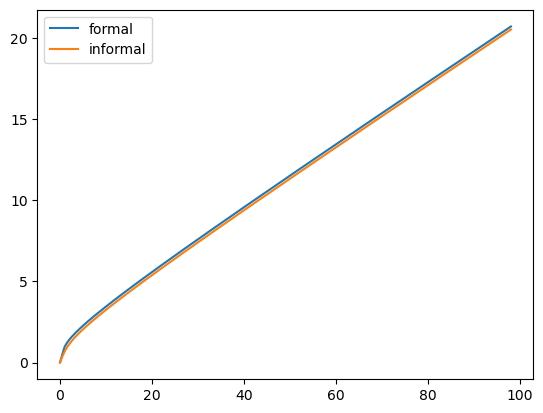

In [15]:
plt.plot(mGrid, Agent_GE.solution[0].cFunc[0](mGrid), label = 'formal')
plt.plot(mGrid, Agent_GE.solution[0].cFunc[1](mGrid), label = 'informal')

plt.legend()

In [16]:
start = time.time()

CJACR, AJACR = Agent_GE.calc_jacobian('Rfree',0,T)
CJACZ, AJACZ = Agent_GE.calc_jacobian('labor',0, T)

print('Seconds to calculate Jacobian', time.time() - start)

Seconds to calculate Jacobian 9.74699878692627


In [17]:
### Input changes for only one agent
start = time.time()

CJACR_f, AJACR_f = Agent_GE.calc_jacobian('Rfree',1,T)
CJACZ_f, AJACZ_f = Agent_GE.calc_jacobian('labor', 1,T)

CJACR_i, AJACR_i = Agent_GE.calc_jacobian('Rfree',2,T)
CJACZ_i, AJACZ_i = Agent_GE.calc_jacobian('labor', 2,T)
print('Seconds to calculate Jacobian', time.time() - start)


Seconds to calculate Jacobian 20.342272996902466


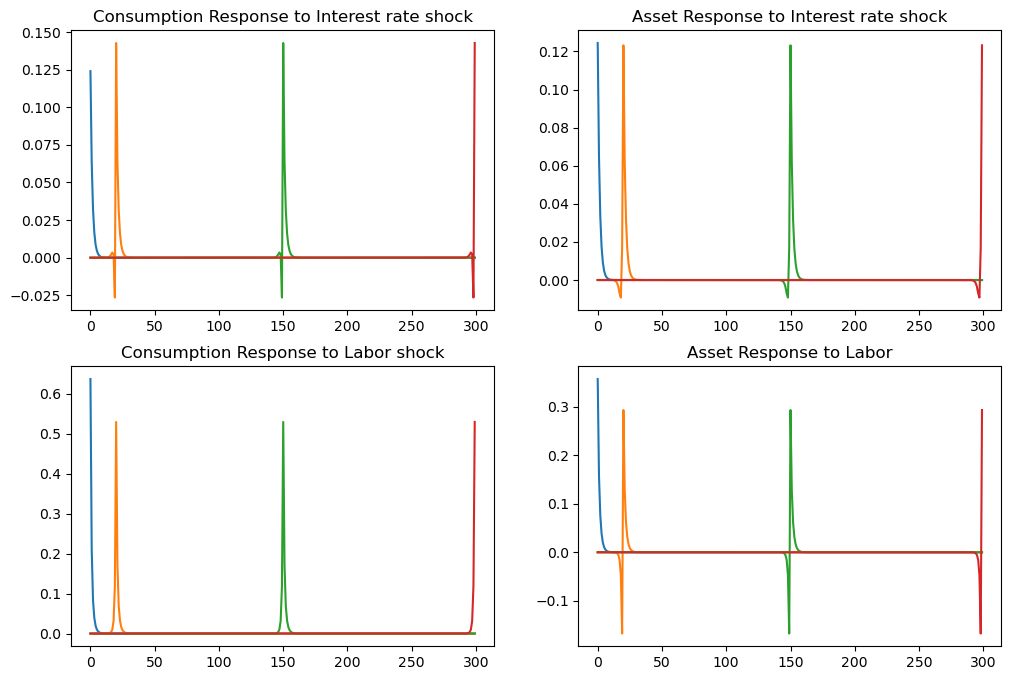

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Consumption Response to Interest rate shock
axs[0, 0].plot(CJACR.T[0])
axs[0, 0].plot(CJACR.T[20])
axs[0, 0].plot(CJACR.T[150])
axs[0, 0].plot(CJACR.T[-1])
axs[0, 0].set_title("Consumption Response to Interest rate shock")

# Asset Response to Interest rate shock
axs[0, 1].plot(AJACR.T[0])
axs[0, 1].plot(AJACR.T[20])
axs[0, 1].plot(AJACR.T[150])
axs[0, 1].plot(AJACR.T[-1])
axs[0, 1].set_title("Asset Response to Interest rate shock")

# Consumption Response to Labor shock
axs[1, 0].plot(CJACZ.T[0])
axs[1, 0].plot(CJACZ.T[20])
axs[1, 0].plot(CJACZ.T[150])
axs[1, 0].plot(CJACZ.T[-1])
axs[1, 0].set_title("Consumption Response to Labor shock")

# Asset Response to Labor
axs[1, 1].plot(AJACZ.T[0])
axs[1, 1].plot(AJACZ.T[20])
axs[1, 1].plot(AJACZ.T[150])
axs[1, 1].plot(AJACZ.T[-1])
axs[1, 1].set_title("Asset Response to Labor")

plt.show()

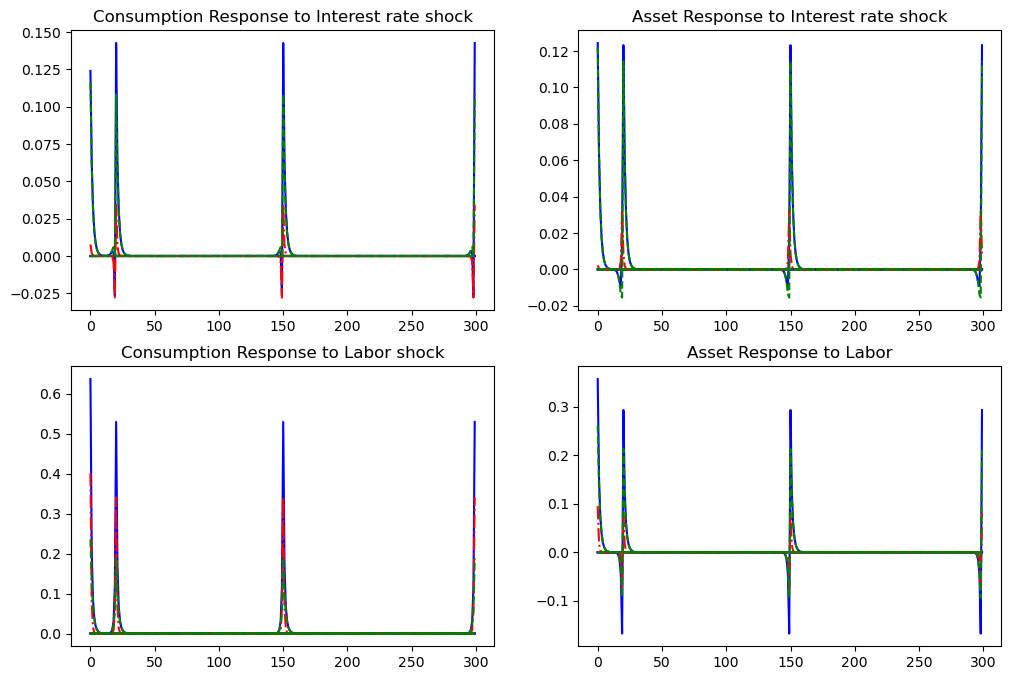

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Consumption Response to Interest rate shock
axs[0, 0].plot(CJACR.T[0], color = 'blue')
axs[0, 0].plot(CJACR.T[20], color = 'blue')
axs[0, 0].plot(CJACR.T[150], color = 'blue')
axs[0, 0].plot(CJACR.T[-1], color = 'blue')
axs[0, 0].plot(CJACR_f.T[0], '-.', color = 'red', label = 'formal')
axs[0, 0].plot(CJACR_f.T[20], '-.', color = 'red', label = 'formal')
axs[0, 0].plot(CJACR_f.T[150], '-.', color = 'red', label = 'formal')
axs[0, 0].plot(CJACR_f.T[-1], '-.', color = 'red', label = 'formal')
axs[0, 0].plot(CJACR_i.T[0], '--', color = 'green', label = 'informal')
axs[0, 0].plot(CJACR_i.T[20], '--', color = 'green', label = 'informal')
axs[0, 0].plot(CJACR_i.T[150], '--', color = 'green', label = 'informal')
axs[0, 0].plot(CJACR_i.T[-1], '--', color = 'green', label = 'informal')
axs[0, 0].set_title("Consumption Response to Interest rate shock")

# Asset Response to Interest rate shock
axs[0, 1].plot(AJACR.T[0], color = 'blue')
axs[0, 1].plot(AJACR.T[20], color = 'blue')
axs[0, 1].plot(AJACR.T[150], color = 'blue')
axs[0, 1].plot(AJACR.T[-1], color = 'blue')
axs[0, 1].plot(AJACR_f.T[0], '-.', color = 'red', label = 'formal')
axs[0, 1].plot(AJACR_f.T[20], '-.', color = 'red', label = 'formal')
axs[0, 1].plot(AJACR_f.T[150], '-.', color = 'red', label = 'formal')
axs[0, 1].plot(AJACR_f.T[-1], '-.', color = 'red', label = 'formal')
axs[0, 1].plot(AJACR_i.T[0], '--', color = 'green', label = 'informal')
axs[0, 1].plot(AJACR_i.T[20], '--', color = 'green', label = 'informal')
axs[0, 1].plot(AJACR_i.T[150], '--', color = 'green', label = 'informal')
axs[0, 1].plot(AJACR_i.T[-1], '--', color = 'green', label = 'informal')
axs[0, 1].set_title("Asset Response to Interest rate shock")

# Consumption Response to Labor shock
axs[1, 0].plot(CJACZ.T[0], color = 'blue')
axs[1, 0].plot(CJACZ.T[20], color = 'blue')
axs[1, 0].plot(CJACZ.T[150], color = 'blue')
axs[1, 0].plot(CJACZ.T[-1], color = 'blue')
axs[1, 0].plot(CJACZ_f.T[0], '-.', color = 'red', label = 'formal')
axs[1, 0].plot(CJACZ_f.T[20], '-.', color = 'red', label = 'formal')
axs[1, 0].plot(CJACZ_f.T[150], '-.', color = 'red', label = 'formal')
axs[1, 0].plot(CJACZ_f.T[-1], '-.', color = 'red', label = 'formal')
axs[1, 0].plot(CJACZ_i.T[0], '--', color = 'green', label = 'informal')
axs[1, 0].plot(CJACZ_i.T[20], '--', color = 'green', label = 'informal')
axs[1, 0].plot(CJACZ_i.T[150], '--', color = 'green', label = 'informal')
axs[1, 0].plot(CJACZ_i.T[-1], '--', color = 'green', label = 'informal')
axs[1, 0].set_title("Consumption Response to Labor shock")

# Asset Response to Labor
axs[1, 1].plot(AJACZ.T[0], color = 'blue')
axs[1, 1].plot(AJACZ.T[20], color = 'blue')
axs[1, 1].plot(AJACZ.T[150], color = 'blue')
axs[1, 1].plot(AJACZ.T[-1], color = 'blue')
axs[1, 1].plot(AJACZ_f.T[0], '-.', color = 'red', label = 'formal')
axs[1, 1].plot(AJACZ_f.T[20], '-.', color = 'red', label = 'formal')
axs[1, 1].plot(AJACZ_f.T[150], '-.', color = 'red', label = 'formal')
axs[1, 1].plot(AJACZ_f.T[-1], '-.', color = 'red', label = 'formal')
axs[1, 1].plot(AJACZ_i.T[0], '--', color = 'green', label = 'informal')
axs[1, 1].plot(AJACZ_i.T[20], '--', color = 'green', label = 'informal')
axs[1, 1].plot(AJACZ_i.T[150], '--', color = 'green', label = 'informal')
axs[1, 1].plot(AJACZ_i.T[-1], '--', color = 'green', label = 'informal')
axs[1, 1].set_title("Asset Response to Labor")

plt.show()

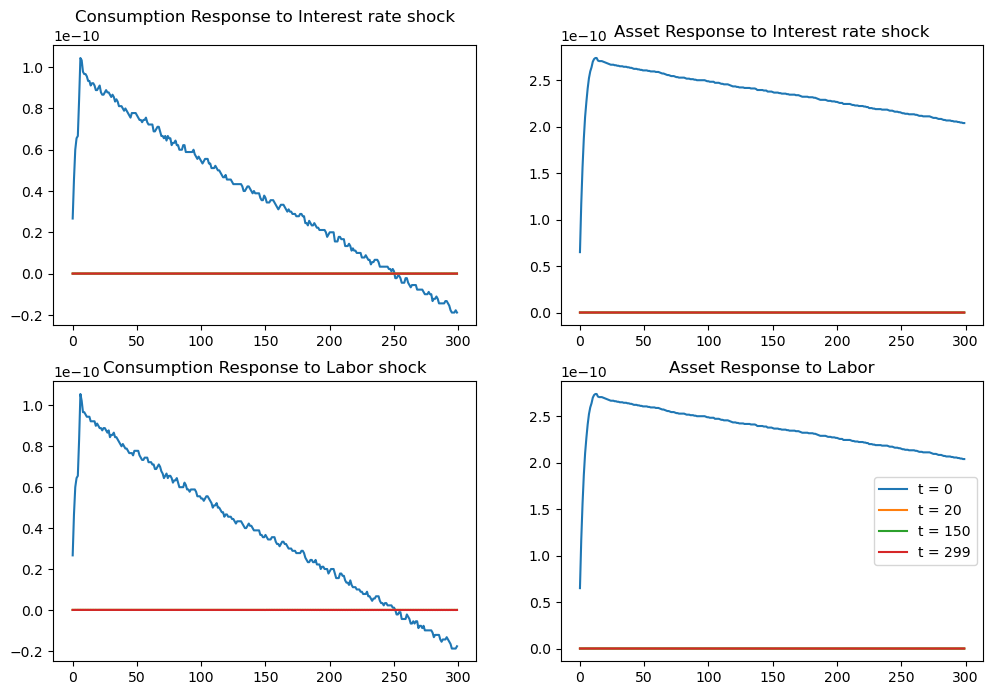

In [20]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Consumption Response to Interest rate shock
axs[0, 0].plot(CJACR.T[0] - CJACR_f.T[0] - CJACR_i.T[0], label = 't = 0')
axs[0, 0].plot(CJACR.T[20] - CJACR_f.T[20] - CJACR_i.T[20], label = 't = 20')
axs[0, 0].plot(CJACR.T[150] - CJACR_f.T[150] - CJACR_i.T[150], label = 't = 150')
axs[0, 0].plot(CJACR.T[-1] - CJACR_f.T[-1] - CJACR_i.T[-1], label = 't = 299')
axs[0, 0].set_title("Consumption Response to Interest rate shock")

# Asset Response to Interest rate shock
axs[0, 1].plot(AJACR.T[0] - AJACR_f.T[0] - AJACR_i.T[0], label = 't = 0')
axs[0, 1].plot(AJACR.T[20] - AJACR_f.T[20] - AJACR_i.T[20], label = 't = 20')
axs[0, 1].plot(AJACR.T[150] - AJACR_f.T[150] - AJACR_i.T[150], label = 't = 150')
axs[0, 1].plot(AJACR.T[-1] - AJACR_f.T[-1] - AJACR_i.T[-1], label = 't = 299')
axs[0, 1].set_title("Asset Response to Interest rate shock")

# Consumption Response to Labor shock
axs[1, 0].plot(CJACZ.T[0] - CJACZ_f.T[0] - CJACZ_i.T[0], label = 't = 0')
axs[1, 0].plot(CJACZ.T[20] - CJACZ_f.T[20] - CJACZ_i.T[20], label = 't = 20')
axs[1, 0].plot(CJACZ.T[150] - CJACZ_f.T[150] - CJACZ_i.T[150], label = 't = 150')
axs[1, 0].plot(CJACZ.T[-1] - CJACZ_f.T[-1] - CJACZ_i.T[-1], label = 't = 299')
axs[1, 0].set_title("Consumption Response to Labor shock")

# Asset Response to Labor
axs[1, 1].plot(AJACZ.T[0] - AJACZ_f.T[0] - AJACZ_i.T[0], label = 't = 0')
axs[1, 1].plot(AJACZ.T[20] - AJACZ_f.T[20] - AJACZ_i.T[20], label = 't = 20')
axs[1, 1].plot(AJACZ.T[150] - AJACZ_f.T[150] - AJACZ_i.T[150], label = 't = 150')
axs[1, 1].plot(AJACZ.T[-1] - AJACZ_f.T[-1] - AJACZ_i.T[-1], label = 't = 299')
axs[1, 1].set_title("Asset Response to Labor")
plt.legend()
plt.show()

In [21]:
HARK_SteadyState_Dict = SteadyStateDict({"C": C_ss, "r": r_ss, "Y": Y_ss, "B": B_ss, "G": G_ss, "A": A_ss})
HARK_Jacobian_Dict = JacobianDict( { 'C' : {'Zf' : CJACZ_f, 'Zi': CJACZ_i, 'r': CJACR} ,'A' : {'Zf' : AJACZ_f, 'Zi': AJACZ_i, 'r': AJACR}}) 

In [22]:
@sj.simple
def fiscal(B, r, G, Y): 
    T = (1 + r) * B(-1) + G - B # total tax burden
    Z = Y - T
    Zf = Z * pformal_share * wage_share - T #Need to pay taxes for the other one
    Zi = Z/ (pformal_share * wage_share) + T    
    # Zf = Y *pformal_share * wage_share - T
    # Zi = Y/ (pformal_share * wage_share) - T
    deficit = G - T
    # return T, Z, deficit
    return T, Zf, Zi, deficit

# @sj.simple
# def labor(Z, T):
#     Zf = Z * pformal_share * wage_share - T #Need to pay taxes for the other one
#     Zi = Z/ (pformal_share * wage_share) + T
#     return Zf, Zi

@sj.simple
def mkt_clearing(A, B, Y, C, G):
    asset_mkt = A - B
    goods_mkt = C + G - Y
    
    return asset_mkt, goods_mkt

In [23]:
# Create the model and specify attributes
# HARK_HANK = create_model([HARK_Jacobian_Dict, fiscal, mkt_clearing], name="HARK_HANK")
HARK_HANK = create_model([HARK_Jacobian_Dict, fiscal, mkt_clearing], name="HARK_HANK")
unknowns = ['Y']
targets = ['asset_mkt']
exogenous = ['G']

In [24]:
# First, we analyze a government spending shock.
G_std = .01
G_persistence = .8
dG =  G_std * G_persistence**np.arange(T)
shocks_G = {"G": dG}

In [25]:
# Create the IRFs
irfs_G = HARK_HANK.solve_impulse_linear(HARK_SteadyState_Dict, unknowns, targets, shocks_G)

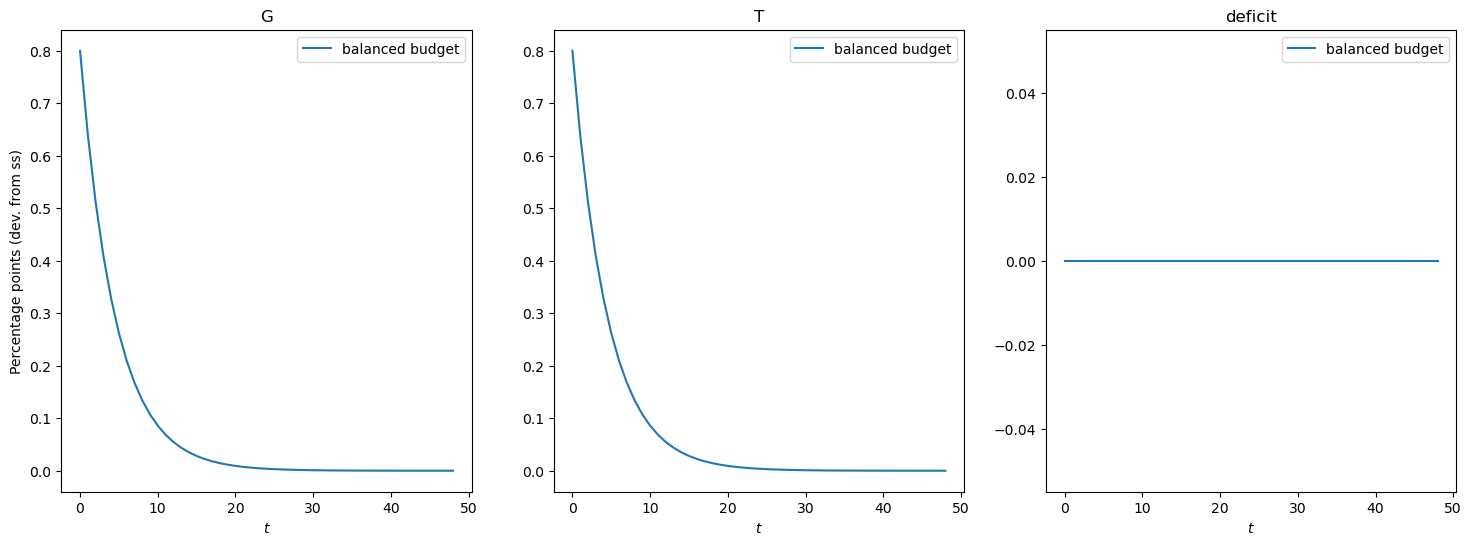

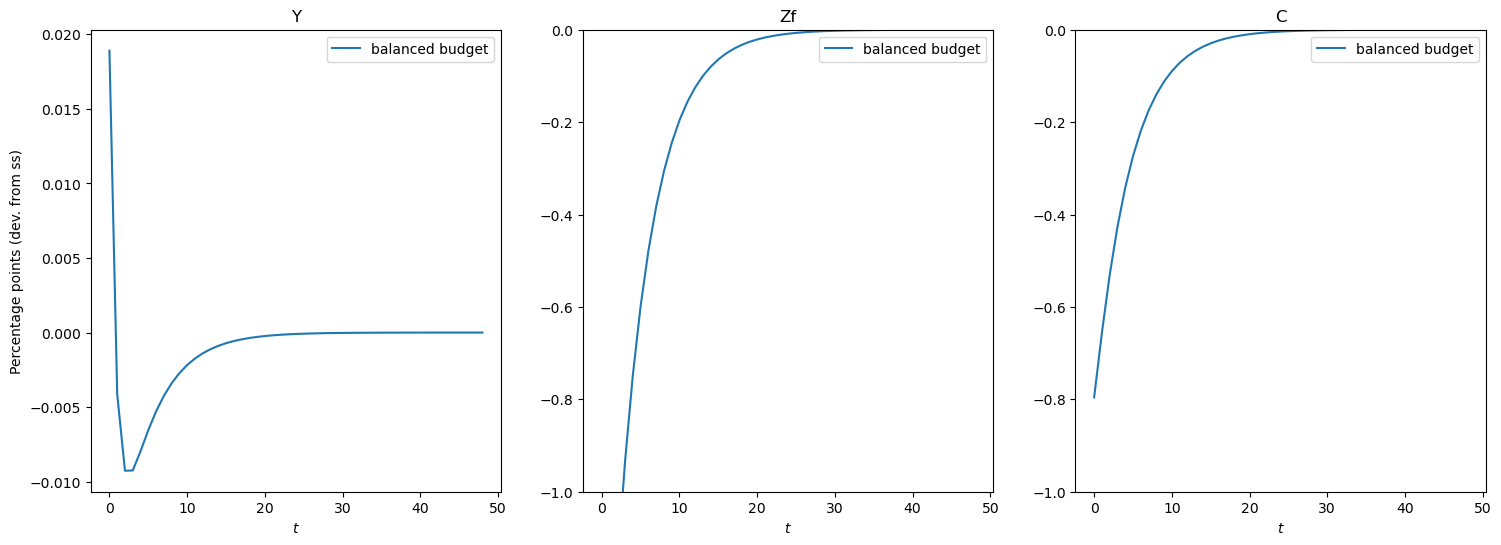

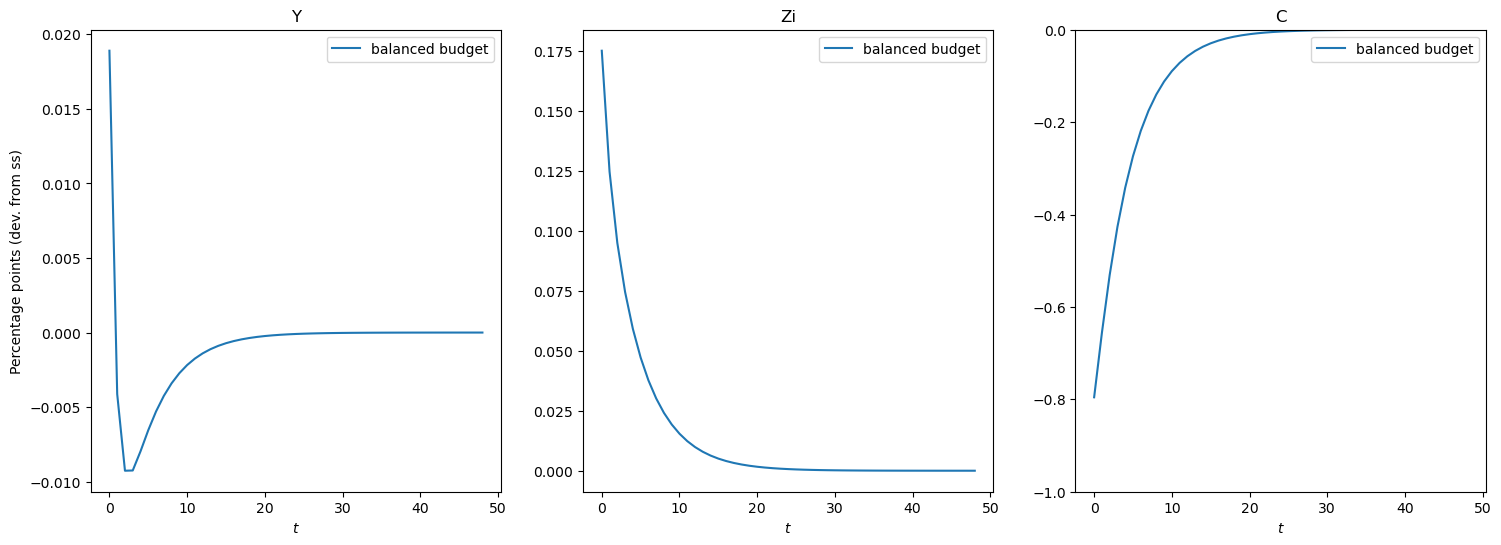

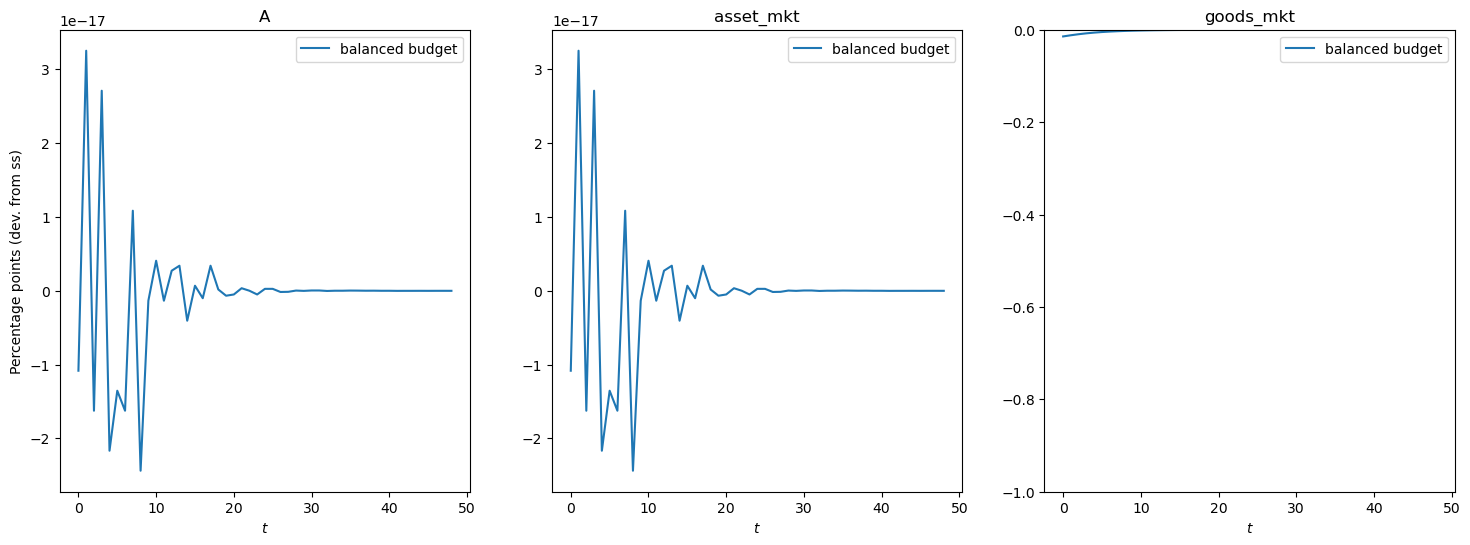

In [26]:
# Plot them
show_irfs([irfs_G], ['G', 'T', 'deficit'], labels=["balanced budget"])
show_irfs([irfs_G], ['Y', 'Zf', 'C'], labels=["balanced budget"])
show_irfs([irfs_G], ['Y', 'Zi', 'C'], labels=["balanced budget"])
show_irfs([irfs_G], ['A','asset_mkt', 'goods_mkt'], labels=["balanced budget"])

In [27]:
# Deficit Spending
rho_B = 0.8
dB = np.cumsum(dG) * rho_B ** np.arange(T)
shocks_B = {'G': dG, 'B': dB} #

irfs_B = HARK_HANK.solve_impulse_linear(HARK_SteadyState_Dict, unknowns, targets, shocks_B)

In [28]:
print(C_ss, r_ss, Y_ss, B_ss)

0.824531253825834 0.030000000000000027 1.0 0.25


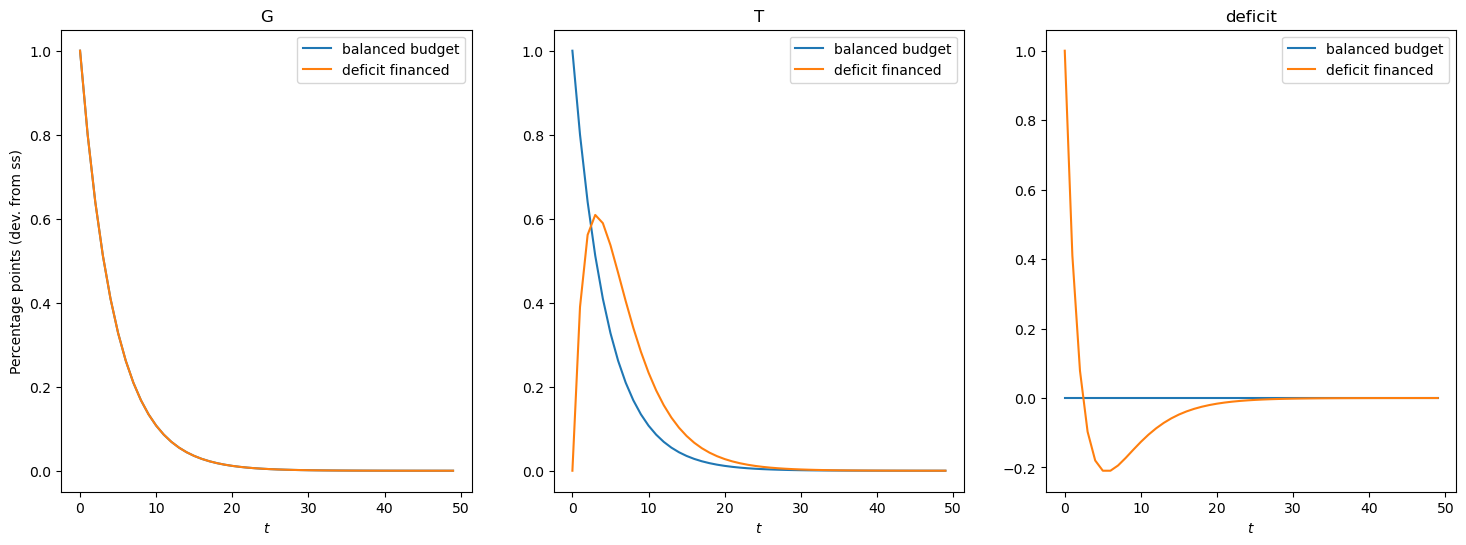

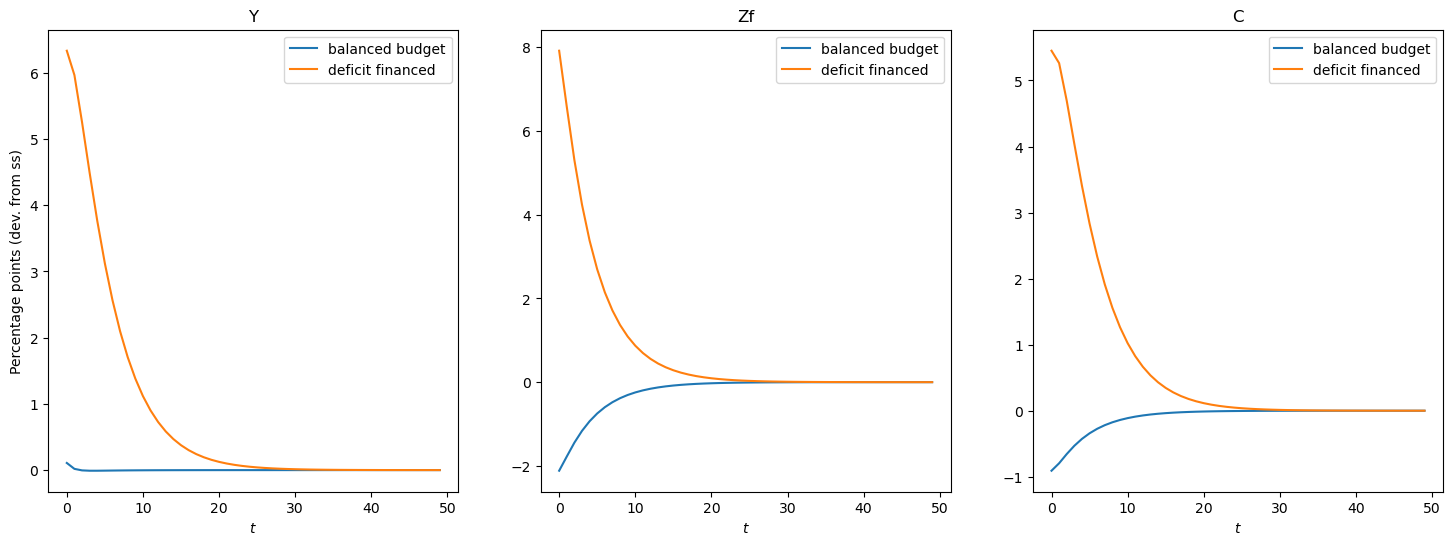

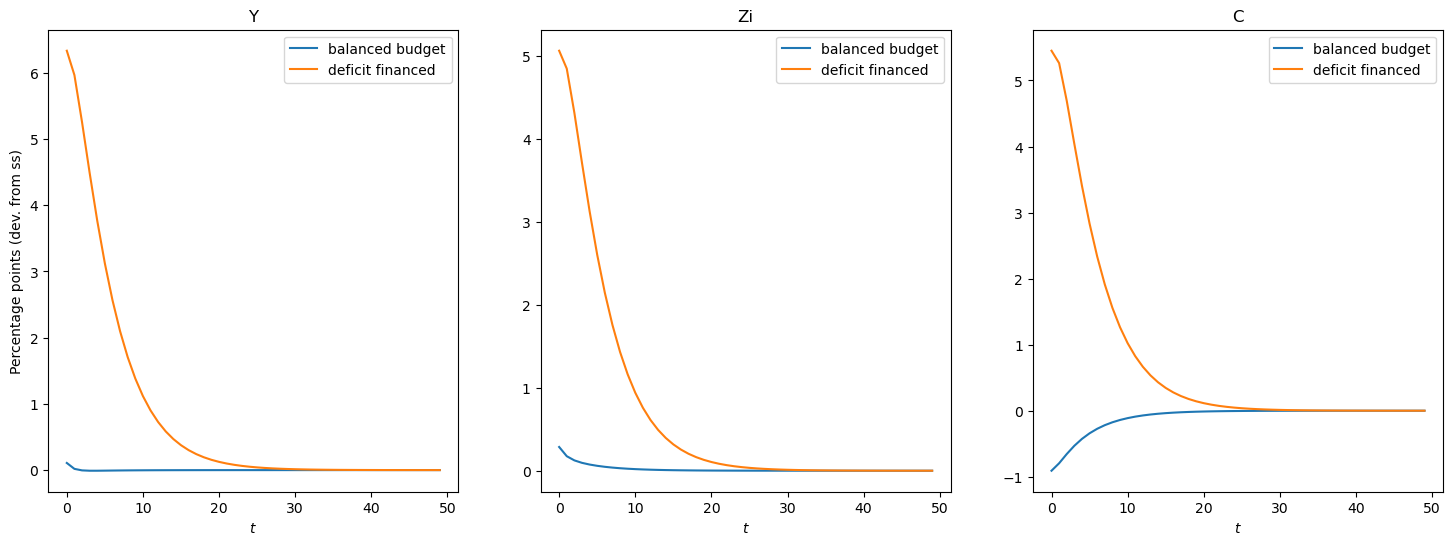

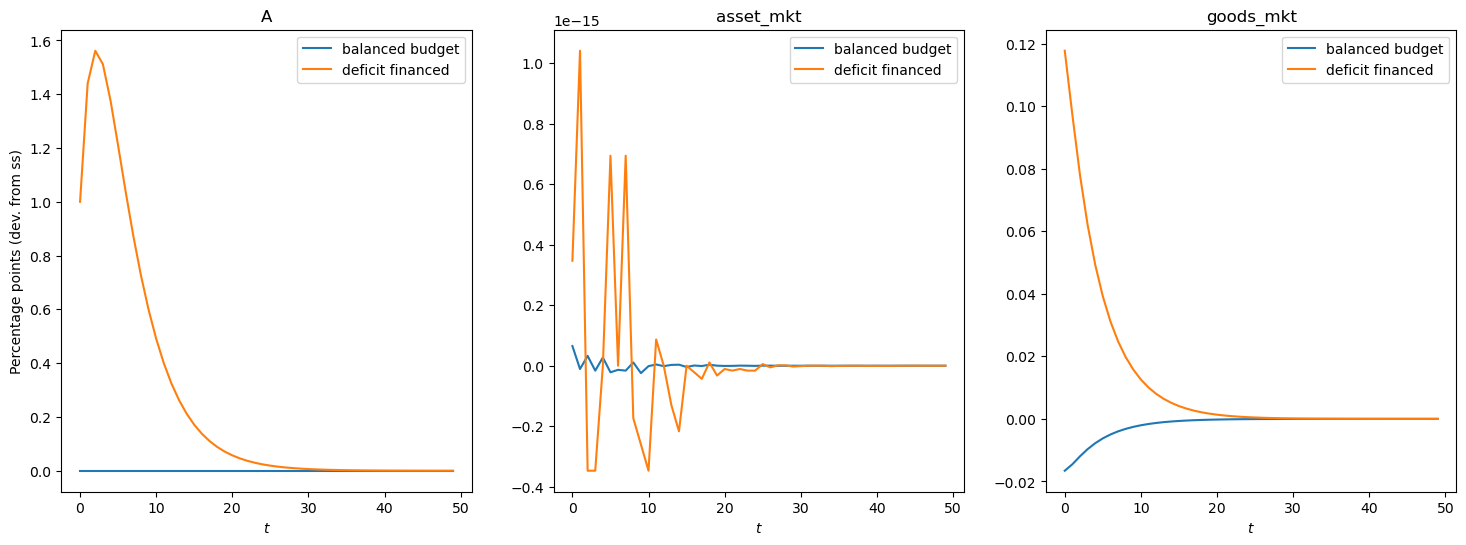

In [31]:
show_irfs([irfs_G, irfs_B], ['G', 'T', 'deficit'], labels=["balanced budget", "deficit financed"])
show_irfs([irfs_G, irfs_B], ['Y', 'Zf', 'C'], labels=["balanced budget", "deficit financed"])
show_irfs([irfs_G, irfs_B], ['Y', 'Zi', 'C'], labels=["balanced budget", "deficit financed"])
show_irfs([irfs_G, irfs_B], ['A', 'asset_mkt', 'goods_mkt'], labels=["balanced budget", "deficit financed"])